# Temporal Pathway Synthesizer

This notebook is for experimental work for determining how to analyze Yuyu's phosphoproteomic data with the Temporal Pathway Synthesizer

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [2]:
df = pd.read_excel('../input/Mature_Neuron_MT_pMS_Stabilizer1_2_time_course_ys.xlsx')

In this example we analyze the data for Stabilizer 1 (EpoB). Phosphorylation levels for 3820 peptides in 1746 proteins are measured at times 0, 10min, 60min, 2hr, 6hr. We first capture just the phosphorylation levels at these time points

## P-value calculations

TPS requires files with p-values for differences in phosphorylation between each timepoint and the initial timepoint and also for differences in phosphorylation between successive timepoints. We do not have replicates so cannot calculate these honestly. We will assume as null hypothesis that the differences between timepoints are drawn independently from an empirically derived normal distribution.

In [6]:
time_series = df.iloc[:, 21:26]
time_series.columns = ['0min', '10min', '60min', '2hr', '6hr']

Then we get the differences in phosphorylation between each pair of timepoints

In [125]:
diffs = pd.DataFrame(index=time_series.index)

In [126]:
for i in range(time_series.shape[1]):
    for j in range(i+1, time_series.shape[1]):
        diffs[f'{time_series.columns[j]}-{time_series.columns[i]}'] = \
            time_series.iloc[:, j] - time_series.iloc[:, i]

In [119]:
foldC = pd.DataFrame(index=time_series.index)

In [123]:
for i in range(time_series.shape[1]):
    for j in range(i+1, time_series.shape[1]):
        foldC[f'{time_series.columns[j]}-{time_series.columns[i]}'] = \
            time_series.iloc[:, j]/time_series.iloc[:, i]

In [124]:
foldC

,10min-0min,60min-0min,2hr-0min,6hr-0min,60min-10min,2hr-10min,6hr-10min,2hr-60min,6hr-60min,6hr-2hr
0,0.935835,1.307107,0.946208,0.883898,1.396728,1.011084,0.944503,0.723895,0.676225,0.934149
1,0.984467,0.863819,1.114448,0.942673,0.877449,1.132032,0.957546,1.290140,1.091285,0.845865
2,1.306042,0.760834,0.648836,0.740406,0.582549,0.496795,0.566908,0.852795,0.973150,1.141130
3,0.985812,0.775223,0.784205,0.750142,0.786380,0.795491,0.760938,1.011586,0.967646,0.956564
4,0.397304,0.742361,0.793791,0.770174,1.868497,1.997945,1.938502,1.069279,1.037466,0.970248
5,0.781544,1.294737,1.275449,0.924067,1.656641,1.631961,1.182362,0.985102,0.713710,0.724504
6,1.228143,1.139583,1.084514,1.057811,0.927891,0.883052,0.861310,0.951676,0.928244,0.975378
7,1.004674,1.299354,1.228098,1.270107,1.293308,1.222384,1.264198,0.945161,0.977491,1.034206
8,1.301365,0.701647,0.988803,0.887850,0.539162,0.759820,0.682245,1.409260,1.265380,0.897904
9,0.638569,1.029637,0.858644,0.644516,1.612412,1.344638,1.009313,0.833929,0.625964,0.750621


Let's take a look at the distribution of all differences at all timepoints

In [11]:
all_differences = diffs.values.flatten()

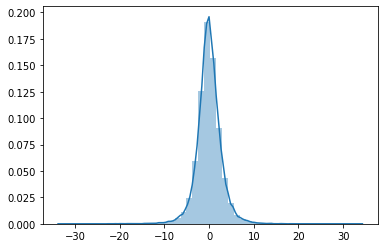

In [12]:
sns.distplot(all_differences)

In [14]:
print(f'mean: {np.mean(all_differences)}, std: {np.std(all_differences)}')

mean: -0.033162071447285946, std: 2.779171625597911


We do not need to run a normality test to see this is normally distributed, but let's run it anyway

In [16]:
st.normaltest(all_differences)

NormaltestResult(statistic=6429.321357675435, pvalue=0.0)

In [127]:
all_fold_changes = foldC.values.flatten()

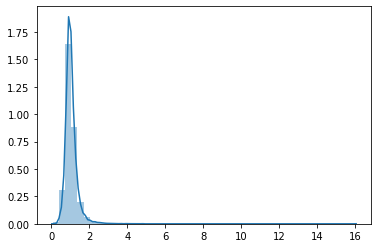

In [128]:
sns.distplot(all_fold_changes)

In [129]:
print(f'mean: {np.mean(all_fold_changes)}, std: {np.std(all_fold_changes)}')

mean: 1.045400504911533, std: 0.3551419115146921


NormaltestResult(statistic=22.674474692924708, pvalue=1.1920662172779046e-05)

Let's assume that differences between any two time points are independently drawn from a normal distribution with mean 0 and standard deviation 2.77917...

For any difference we can calculate the probability of observing a difference at least as extreme.

In [20]:
z_scores = diffs/np.std(all_differences)
p_values = z_scores.apply(lambda x: 2*(1 - st.norm.cdf(abs(x))))

In [21]:
p_values

,10min-0min,60min-0min,2hr-0min,6hr-0min,60min-10min,2hr-10min,6hr-10min,2hr-60min,6hr-60min,6hr-2hr
0,0.829065,0.301443,0.856368,0.696052,0.211576,0.972158,0.861273,0.224617,0.154447,0.833936
1,0.953983,0.612914,0.670705,0.831347,0.654000,0.629176,0.876610,0.351802,0.769564,0.523373
2,0.199769,0.316332,0.141221,0.276767,0.022358,0.005897,0.017797,0.638902,0.931795,0.701240
3,0.953683,0.357471,0.377007,0.306368,0.388625,0.409177,0.334649,0.970668,0.918219,0.889096
4,0.004114,0.219993,0.326246,0.273895,0.100442,0.059085,0.075877,0.806577,0.894659,0.910480
5,0.475762,0.335975,0.368556,0.804230,0.093879,0.106893,0.641746,0.949793,0.226269,0.251357
6,0.455688,0.648104,0.782289,0.850072,0.772147,0.638620,0.577569,0.857105,0.789184,0.930425
7,0.989145,0.383601,0.506762,0.431776,0.391072,0.515510,0.439788,0.835703,0.932163,0.902686
8,0.220888,0.225538,0.963723,0.648705,0.014846,0.204208,0.093009,0.243432,0.449426,0.681748
9,0.127206,0.900473,0.550834,0.133584,0.098887,0.353045,0.979979,0.470556,0.104124,0.366205


We can observe the number of examples with "p_value" less than 0.05

In [100]:
(p_values < 0.001).sum()

10min-0min     63
60min-0min     58
2hr-0min       20
6hr-0min       18
60min-10min    60
2hr-10min      57
6hr-10min      75
2hr-60min       7
6hr-60min      26
6hr-2hr         5
dtype: int64

This p-values must be corrected for multiple comparisons. Let's use Benjamini Hochberg. First let's filter to only columns of interest.

In [53]:
p_relevant = p_values.iloc[:, [0, 1, 2, 3, 4, 7, 9]]
p_flat = p_relevant.values.flatten()

In [55]:
m = multipletests(p_flat, method='fdr_bh')

In [94]:
corrected = m[1]
correction_map = {p: q for p, q in zip(p_flat, corrected)}

This correction now appears far too conservative. Let's keep the original p-values for now. There's no theoretical basis behind this that I'm aware of, but the TPS authors claim that the network discovered is not very sensitive to the choice of significant p-value cutoff.

In [113]:
p_values['peptide'] = p_values.index.map(lambda x: 'P' + str(x))
p_first = p_values.iloc[:, [-1, 0, 1, 2, 3]].copy()
p_prev = p_values.iloc[:, [-1, 0, 4, 7, 9]].copy()

In [118]:
p_first.to_csv('../work/EpoB_p_values_first.tsv', sep='\t', header=False, index=False)
p_prev.to_csv('../work/EpoB_p_values_prev.tsv', sep='\t', header=False, index=False)

## Peptide Mapping

TPS asks for a mapping between peptides and the proteins they live inside. These are used in the output to aid in the interpretation of results. Timeseries and p-value files have rows corresponding to peptides. The peptide ID's they use are based on the sequences, but have numbers that I do not yet understand. The sequences in Yuyu's data are not unique, but this may be in error. Let's investigate

There is a column in Yuyu's data called `Site Position` that gives the site position of the phosphorylation in the given protein. Some peptides have multiple sites. In `sequence`, the `#` character is used to denote sites. The number of sites referred to in `Site Position` should match the number of `#`s in `sequence`. Let's check

In [38]:
df['num_sharps'] = df['sequence'].apply(lambda x: x.count('#'))
df['num_site_positions'] = df['Site Position'].apply(lambda x: len(str(x).split(';')))

In [39]:
suspicious = (df['num_sharps'] != df['num_site_positions'])

In [40]:
suspicious.sum()

108

There are 108 examples where this is not the case.

In [46]:
df[suspicious][['Site Position', 'sequence']]

,Site Position,sequence
19,620,K.VGSLT#PPSS#PK.T
23,108,K.LSVPT#S#DEEDEVPAPK.P
24,109,K.LSVPT#S#DEEDEVPAPK.P
82,681,K.IEEVLSPEGS#PSKS#PSK.K
84,677,K.IEEVLS#PEGS#PSK.S
130,5752,K.AS#LGS#LEGEAEAEASSPK.G
166,112,R.AATAARPPAPPPAPQPPS#PTPS#PPRPTLAR.E
271,193,K.S#PPLS#PVGTTPVK.L
283,1203,R.IEDS#EPHIPLIDDT#DAEDDAPTK.R
337,1003,R.AS#PEPQRENAS#PAPGTTAEEAM*SR.G


There's definitely some discrepency here. This can be reevaulated later